## Introduction

Natural language is a broad term but you can consider it to cover any of the following:
* Text (email, blog post, book, Tweet)
* Speech (conversation you have, voice commands you give)

> These types of data are often referred to as *sequences* (a sentence is a sequence of words). 

> So a common term you'll come across in NLP problems is called *seq2seq*, in other words, finding information in one sequence to produce another sequence (e.g. converting a speech command to a sequence of text-based steps).

We will use same steps as used before but with text data.
```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

Different types of sequence problems :

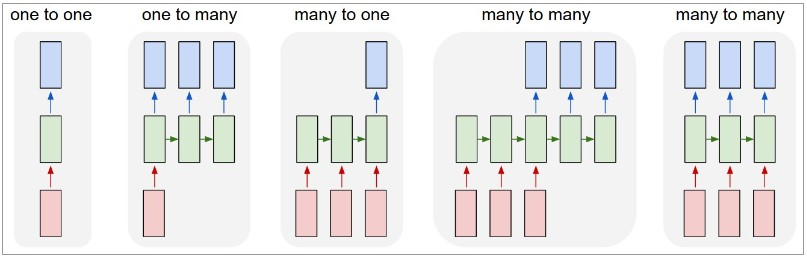


* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5d7776d0-47f7-7a80-1964-658be31231b1)


In [ ]:
# Download some pre-build functions from script
!wget https://raw.githubusercontent.com/sarang-iitb/sarang-iitb/main/sarang.py

--2022-10-10 12:21:11--  https://raw.githubusercontent.com/sarang-iitb/sarang-iitb/main/sarang.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10128 (9.9K) [text/plain]
Saving to: ‘sarang.py.1’

sarang.py.1         100%[===================>]   9.89K  --.-KB/s    in 0s      

2022-10-10 12:21:12 (61.9 MB/s) - ‘sarang.py.1’ saved [10128/10128]



In [ ]:
# Import series of helper functions for the notebook
from sarang import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

This dataset can be found on Kaggle which contains text-based Tweets about natural disasters.

If a tweet contains info about a natural disaster, it is classified as 1 otherwise 0. 

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-10-10 12:21:12--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2022-10-10 12:21:12 (123 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



Unzipping `nlp_getting_started.zip` gives the following 3 `.csv` files:
* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

## Visualizing the text dataset

In [ ]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


What we want to do-
```
Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)
```

In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a **binary classification** problem.

It's fairly balanced too, about 60% negative class (`target = 0`) and 40% positive class (`target = 1`).

Where, 

* `1` = a real disaster Tweet
* `0` = not a real disaster Tweet

And what about the total number of samples we have?

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+3].itertuples():
  _, text, target = row
  
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text: {text}\n")
  print("--------------------------------------------------------------------------------\n")

Target: 0 (not real disaster)
Text: @Stretcher @Rexyy @invalid @Towel let's have babies??!

--------------------------------------------------------------------------------

Target: 0 (not real disaster)
Text: Reusing advanced in life equipments in transit to drumming champaign damage: FdbDP

--------------------------------------------------------------------------------

Target: 0 (not real disaster)
Text: Self destruction mode! ???? https://t.co/ZtYZhbvzqP

--------------------------------------------------------------------------------



### spliting data in train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:
* **Tokenization** - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
  1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being `0`, "love" being `1` and "TensorFlow" being `2`. In this case, every word in a sequence considered a single **token**.
  2. **Character-level tokenization**, such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence considered a single **token**.
  3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.
* **Embeddings** - An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector `[-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]`. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings: 
  1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)) and an embedding representation will be learned during model training.
  2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

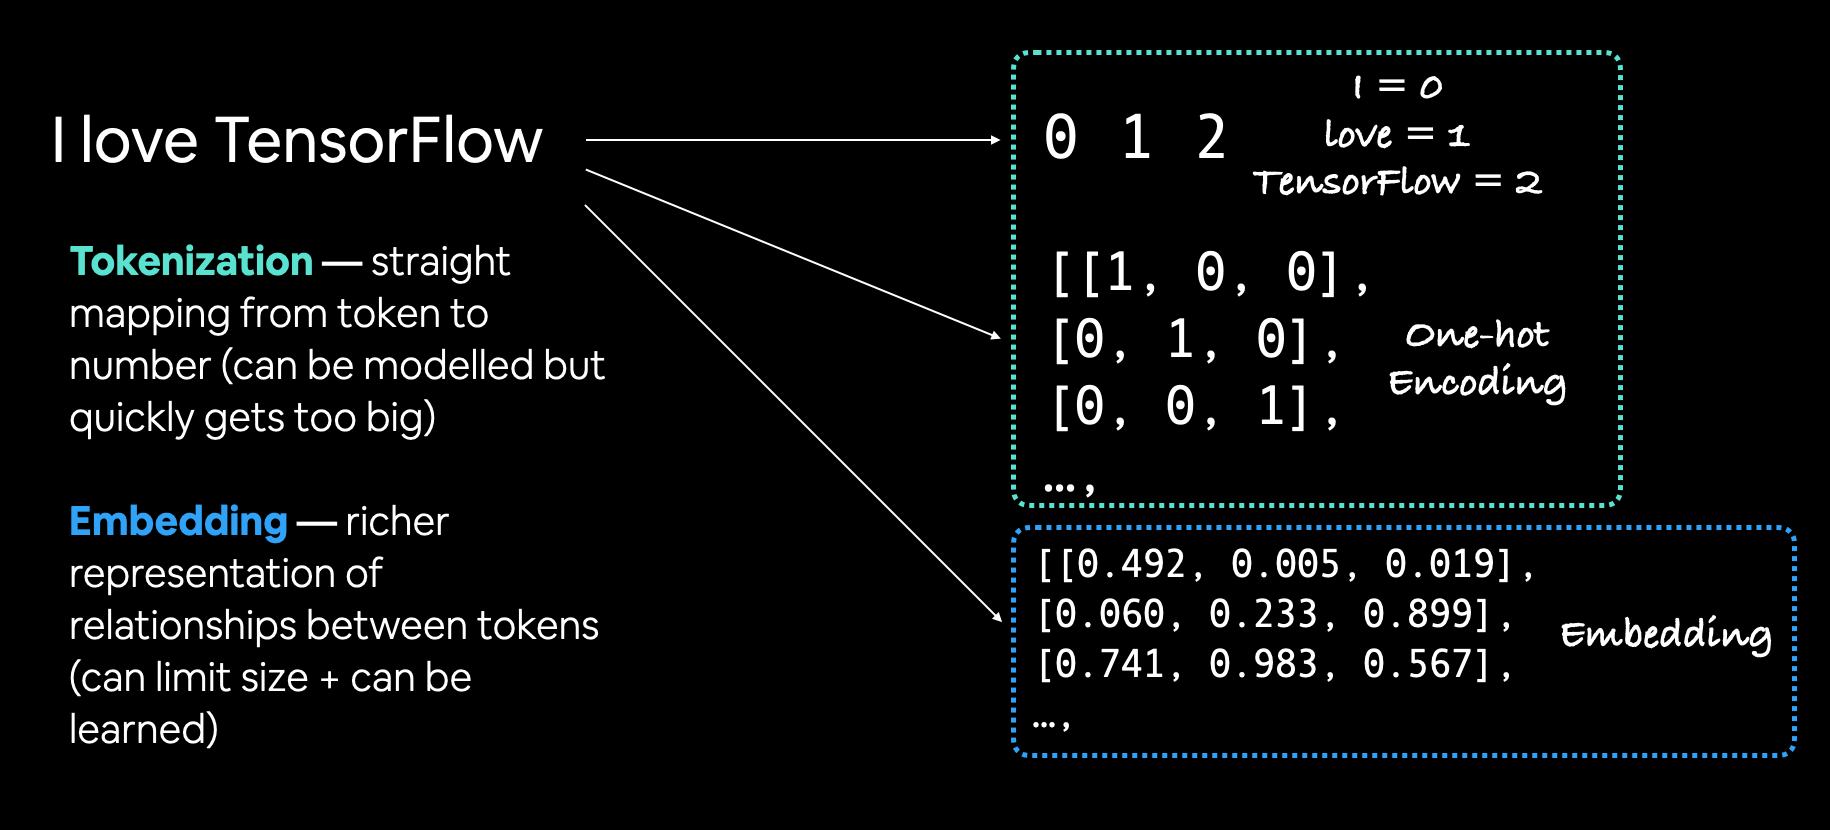

### Text vectorization (tokenization)

To tokenize our words, we'll use the helpful preprocessing layer [`tf.keras.layers.experimental.preprocessing.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization).

The `TextVectorization` layer takes the following parameters:
* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens. 
* `standardize` - Method for standardizing text. Default is `"lower_and_strip_punctuation"` which lowers text and removes all punctuation marks.
* `split` - How to split text, default is `"whitespace"` which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` -  How to output tokens, can be `"int"` (integer mapping), `"binary"` (one-hot encoding), `"count"` or `"tf-idf"`. See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - Defaults to `False`, if `True`, the output feature axis will be padded to `max_tokens` even if the number of unique tokens in the vocabulary is less than `max_tokens`. Only valid in certain modes, see docs for more.

Let's see it in action.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Finally, we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Get that hazard pay      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04084481,  0.0065847 , -0.03601496, ..., -0.01035416,
          0.02637609,  0.02156198],
        [ 0.02277004, -0.04287119,  0.01870605, ...,  0.04251286,
          0.04716172, -0.0266092 ],
        [-0.0309567 , -0.04613679, -0.00598599, ...,  0.04157471,
          0.03749934, -0.03274301],
        ...,
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097],
        [ 0.01645621, -0.00589932, -0.01471175, ..., -0.02511839,
          0.00912381, -0.00024097]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [ ]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04084481,  0.0065847 , -0.03601496, -0.04335672,  0.01426579,
       -0.04864297, -0.01687057, -0.0369377 , -0.00899522, -0.02387161,
        0.00784912, -0.02562865, -0.01832048,  0.01647487,  0.01419561,
        0.04520998, -0.00208694,  0.01621288, -0.00465561, -0.04821272,
        0.00253315, -0.04307612, -0.0235931 , -0.00505779, -0.03602774,
       -0.04848807,  0.03222204,  0.03691274,  0.04468522, -0.04883147,
        0.01700064,  0.0085989 ,  0.04872331,  0.02989744, -0.03421488,
       -0.00967528,  0.00965629, -0.01913964, -0.0025657 , -0.00620096,
        0.04956089, -0.04933487, -0.02818925, -0.04805795,  0.02472896,
        0.04385975,  0.03771955,  0.00953539,  0.03756798, -0.00523137,
        0.03414058,  0.02622986, -0.01831479,  0.02386162, -0.02960638,
       -0.01045404,  0.01137481,  0.03314921, -0.01958164, -0.00352065,
        0.04768685,  0.01426908,  0.00987897, -0.04692049, -0.04439842,
       -0.034595

**The previous two concepts (tokenization and embeddings) are the foundation for many NLP tasks so make sure you read it.**

## Modelling a text dataset


Now that we've got a way to turn our text data into numbers, we can start to build machine learning models to model it.

we'll be building the following:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison



### Model 0: Naive Bayes(baseline)

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

> The curious reader can check out the [Scikit-Learn documentation for more](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# let's evaluate our model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

Model_1 will take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from sarang import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20221010-122114
Epoch 1/5
215/215 [==============================] - 2s 5ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.47668465971946716, 0.787401556968689]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.01504799, -0.03425455, ..., -0.0440354 ,
         -0.01042281,  0.01876437],
        [ 0.04135863, -0.03945086, -0.0381194 , ...,  0.00464736,
          0.03163553,  0.029283  ],
        [ 0.00684031,  0.05363134, -0.00241556, ..., -0.07082178,
         -0.04750704,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.03723461,  0.06267186, -0.07451146, ..., -0.02367217,
         -0.0864333 ,  0.01742155]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "First deep model on text data" \
  --description "Trying a dense model with an embedding layer" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/OFxjfaDSRwqgVK7xbPEVsw/

[2022-10-10T12:21:23] Started scanning logdir.
[2022-10-10T12:21:34] Total uploaded: 240 scalars, 0 tensors, 8 binary objects (2.8 MB)
[2022-10-10T12:21:34] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/OFxjfaDSRwqgVK7xbPEVsw/


In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.4048821 ],
       [0.7443312 ],
       [0.997895  ],
       [0.10890001],
       [0.11143529],
       [0.93556094],
       [0.91345936],
       [0.9925345 ],
       [0.97156817],
       [0.26570338]], dtype=float32)

Since our final layer uses a sigmoid activation function, we get our predictions back in the form of probabilities.

To convert them to prediction classes, we'll use `tf.round()`, meaning prediction probabilities below 0.5 will be rounded to 0 and those above 0.5 will be rounded to 1.

> In practice, the output threshold of a sigmoid prediction probability doesn't necessarily have to 0.5. For example, through testing, you may find that a cut off of 0.25 is better for your chosen evaluation metrics. A common example of this threshold cutoff is the [precision-recall tradeoff](https://en.wikipedia.org/wiki/Precision_and_recall#Introduction) (search to learn more about it).

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

Recurrent neural networks can be used for a number of sequence-based problems:
* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:
* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

### Model 2: LSTM


We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM layer in TensorFlow, we'll use [`tensorflow.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM).

Our model is going to take on a very similar structure to `model_1`:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main difference will be that we're going to add an LSTM layer between our embedding and output.


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20221010-122135
Epoch 1/5
215/215 [==============================] - 4s 9ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[0.007126  ],
        [0.7873676 ],
        [0.9996376 ],
        [0.05679168],
        [0.00258219],
        [0.9996238 ],
        [0.92170197],
        [0.9997993 ],
        [0.9994954 ],
        [0.6645741 ]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

To use the GRU cell in TensorFlow, we can call the [`tensorflow.keras.layers.GRU()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) class.

The architecture of the GRU-powered model will follow the same structure we've been using:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

Again, the only difference will be the layer(s) we use between the embedding and the output.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20221010-122148
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[0.33325273],
        [0.87741184],
        [0.9980252 ],
        [0.11561754],
        [0.01235959],
        [0.9925639 ],
        [0.6214264 ],
        [0.99813336],
        [0.9982377 ],
        [0.50181067]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 4: Bi-directional RNN

Now we're going to look into another kind of RNN, the bidirectional RNN.

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the [`tensorflow.keras.layers.Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) class. We can use the `Bidirectional` class to wrap our existing RNNs, instantly making them bidirectional.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

> **Note:** You can use the `Bidirectional` wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

Our bidirectional model is built, let's compile it.

In [ ]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20221010-122201
Epoch 1/5
215/215 [==============================] - 6s 11ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[0.04000056],
       [0.827929  ],
       [0.99842227],
       [0.13531096],
       [0.00311338],
       [0.99220747],
       [0.95528346],
       [0.99945647],
       [0.99898285],
       [0.28141677]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [ ]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 5: Conv1D

Convolutional neural networks (CNNs) are used for images but they can also be used for sequences.

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

```
Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)
```

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a [`tensorflow.keras.layers.Conv1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) layer followed by a [`tensorflow.keras.layers.GlobablMaxPool1D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) layer.


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)              

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20221010-122215
Epoch 1/5
215/215 [==============================] - 2s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.22534493],
       [0.7534112 ],
       [0.9995602 ],
       [0.05562789],
       [0.01449847],
       [0.9858518 ],
       [0.98418933],
       [0.99758804],
       [0.99862623],
       [0.26914388]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [ ]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Model 6: Pre-trained transfer learning

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through **transfer learning**. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For model_6, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the [Universal Sentence Encoder](https://www.aclweb.org/anthology/D18-2029.pdf) from [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/4) (a great resource containing a plethora of pretrained model resources for a variety of tasks).

>  **Note:** There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.

We can load in a TensorFlow Hub module using the [`hub.load()`](https://www.tensorflow.org/hub/api_docs/python/hub/load) method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


let's build one with the USE as our embedding layer.


We can convert the TensorFlow Hub USE module into a Keras layer using the [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) class.

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221010-122229
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.14443192],
       [0.7271505 ],
       [0.9856655 ],
       [0.19740924],
       [0.7341702 ],
       [0.6859662 ],
       [0.9808888 ],
       [0.9741101 ],
       [0.9157322 ],
       [0.08070079]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


### Model 7: Model 6 with 10% of data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [ ]:
# One way to make data subset
import numpy as np
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [ ]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (`model_6`) using the [`tf.keras.models.clone_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20221010-122249
Epoch 1/5
22/22 [==============================] - 3s 44ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24043241],
       [0.7683785 ],
       [0.90137184],
       [0.29067948],
       [0.57149994],
       [0.83565134],
       [0.8062943 ],
       [0.83358175],
       [0.8554568 ],
       [0.11749925]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Comparing performance of each models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

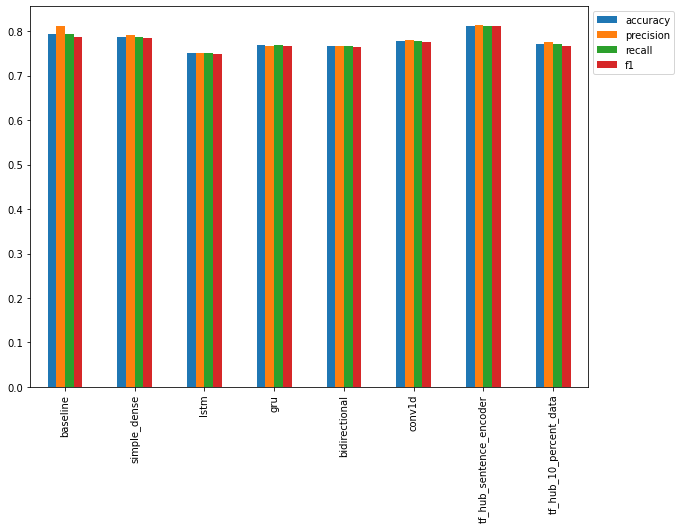

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

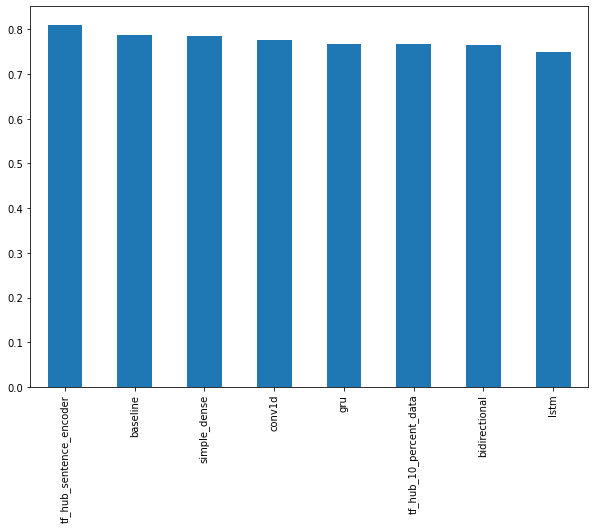

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

The TensorBoard logs of the different modelling experiments we ran can be viewed.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs \
  --name "NLP modelling experiments" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/xfd6oYu9Qp6eZa0znXhknQ/

[2022-10-10T12:23:01] Started scanning logdir.
[2022-10-10T12:23:21] Total uploaded: 420 scalars, 0 tensors, 14 binary objects (5.5 MB)
[2022-10-10T12:23:21] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/xfd6oYu9Qp6eZa0znXhknQ/
